In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.linalg as la

In [51]:
# --- import eigenvalues and eigenvectors calculated previously --- #

eigenvalues = np.loadtxt('/Users/pedrobraga/Documents/Cambridge/wa_two/repo_wa_two/excitonic_states/Eigenvalues5.txt')
eigenvectors = np.loadtxt('/Users/pedrobraga/Documents/Cambridge/wa_two/repo_wa_two/excitonic_states/Eigenvectors5.txt')

In [91]:
# --- global variables --- #

hbar = 0.658 # eV fs
m0 = 5.6856800 # fs2 eV/nm2
mu = 0.108 * m0 # fs2 eV/nm2
kb = 8.681e-5 # ev K {-1}

veps0 = 5.52638e-2 # c{2} eV{-1} mum{-1}
vepsS = 3.32 # dimless
vepsW = 6.10 # dimless

Lwell = 0.636 # nm
r0 = Lwell * vepsW/(2*vepsS) # nm

EgZero = 2.565 # ev - zero temperature bandgap energy
n = 1.82 # dimless - refractive index of the medium 
M = 0.44 * m0 # fs2 eV/nm2 - total exciton mass
Msigma = 8 # fs ev nm{-1} - optical matrix element for interband transition
gammaZero = 0.0067 # eV - defect-induced line widgth at T = 0K

DAC = 1.9 # eV - deformation potential for acoustic phonons
DOP = 158 # eV/nm - deformation potential for optical phonons

cAC = 2100 # m/s - acoustic phonon charactetistic velocity
c0 = 299.792 # nm/fs - speed of light in vacuum
hwOP = 35 # meV - optical phonon scattering

alphaOne = 1e-4 # material specific constant for Varshni shift
alphaTwo = 340 # material specific constant for Varshni shift

# --- simulation variables --- #

k_max = .75
N = 500
dk = k_max/N

k_vals = np.linspace(dk, k_max, N)
energies = np.linspace(-10, 10, 1000)

In [92]:
def BandGapEnergy(T):
    return EgZero - (alphaOne * T**2)/(alphaTwo + T)

def ExcitonResonanceEnergy(T, level):
    return eigenvalues[level] #+ BandGapEnergy(T)

def IFFT(level):
    C = dk/(2*np.pi)**0.5
    return np.absolute(C * np.sum(eigenvectors[level]))**2

def Boltzmann(T, level, eigenvalues):
    Z = np.sum(np.exp(-eigenvalues/(kb*T)))
    return np.exp(-eigenvalues[level]/(kb*T))/Z

In [93]:
def RadiativeChannel(level, T):

    C = hbar * Msigma**2 / (2 * m0**2 * n * veps0 * c0)
    return C * IFFT(level) / ExcitonResonanceEnergy(T, level)

In [94]:
for i in [0,1,2,3,4]:

    print(RadiativeChannel(i, 300))

1.5186116656068132
2.36957826655666
4.092012185100468
5.0327040239204655
6.841864013994536


In [95]:
def Photoluminescence(energies, T, eigenvalues):

    C = 2 * Msigma**2 / hbar
    levels = range(len(eigenvalues))

    I = np.zeros(len(energies))

    for i in range(len(energies)):

        summation = 0
        for u in levels:
            summation += RadiativeChannel(u, T) * Boltzmann(T, u, eigenvalues) * IFFT(u) / ((ExcitonResonanceEnergy(T, u) - energies[i])**2 + (RadiativeChannel(u, T) + gammaZero)**2)

        I[i] = C * summation

    return I


In [102]:
PL = Photoluminescence(energies, 300, eigenvalues)

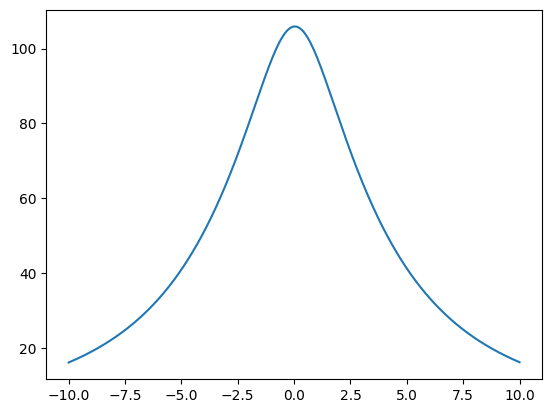

In [103]:
plt.plot(energies, PL)